# Jet Tagging with Convolutional Neural Networks (CNN)

This notebook show how to use a CNN for jet classification between QCD and TT jets using jet images.

## What is a CNN?
A Convolutional Neural Network (CNN) is a type of neural network designed to process grid-like data, such as images. It uses convolutional layers to learn spatial patterns.

## Why use CNNs for Jet Tagging?
- Natural for processing jet images
- Can learn spatial patterns in energy deposits
- Translation invariant
- Parameter efficient

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from jet_utils import load_images, preprocess_jet_images
from jet_plotting_utils import plot_jet_image, plot_training_history, plot_confusion_matrix, plot_roc_curve

2025-07-24 15:40:10.755249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753371611.013731      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753371611.096965      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Load and Prepare Data

We'll use the jet images directly as input to our CNN. Each image represents the energy deposits in the η-φ plane.

In [2]:
X_train, y_train, train_ids, X_val_, y_val, val_ids, X_test, test_ids = load_images()

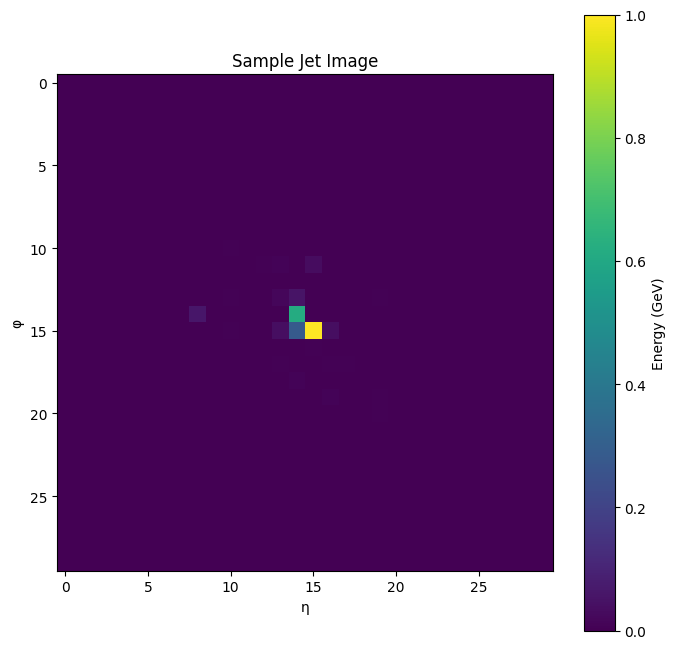

In [3]:

# Visualize a sample jet image
plot_jet_image(X_train[3400, :, :], "Sample Jet Image")#

## 2. Build CNN Model

We'll create a CNN with:
- Convolutional layers to learn spatial patterns
- MaxPooling layers to reduce spatial dimensions
- Dense layers for classification
- Dropout for regularization

In [4]:
optimizer = keras.optimizers.SGD(
    learning_rate=0.05,
    momentum=0.9,
    nesterov=True
)

def build_cnn_model(input_shape):
    model = keras.Sequential([
        # First convolutional block
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),

        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((1, 1)),
        
        # Second convolutional block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((1, 1)),

        # Third convolutional block
        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((1, 1)),
        
        # Fourth convolutional block
        keras.layers.Conv2D(512, (3, 3), activation='relu'),
        
        # Flatten and dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.8),
         keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.8),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create and compile model
model = build_cnn_model(X_train.shape[1:])
model.summary()

2025-07-24 15:40:33.989822: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 247808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,719,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,286,273 (126.98 MB)

 Trainable params: 33,286,145 (126.98 MB)

 Non-trainable params: 128 (512.00 B)

In [5]:
X_train.shape

(3520, 30, 30, 1)

## 3. Train Model

We'll train the CNN with:
- Early stopping to prevent overfitting
- Validation split to monitor performance
- Batch size of 32 for stable training

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # or 'val_accuracy'
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), lr_scheduler
    ]
)

# Plot training history
plot_training_history(history)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6008 - loss: 0.6793 - val_accuracy: 0.6605 - val_loss: 0.6664 - learning_rate: 0.0500
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7110 - loss: 0.5864 - val_accuracy: 0.6605 - val_loss: 0.6441 - learning_rate: 0.0500
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6544 - loss: 0.6449 - val_accuracy: 0.6605 - val_loss: 0.6414 - learning_rate: 0.0500
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6594 - loss: 0.6437 - val_accuracy: 0.6605 - val_loss: 0.6410 - learning_rate: 0.0500
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6554 - loss: 0.6447 - val_accuracy: 0.6605 - val_loss: 0.6410 - learning_rate: 0.0500
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6528 - loss: 0.6469 - val_accuracy: 0.6605 - val_loss: 0.6407 - learning_rate: 0.0500
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.6452 - loss: 0.6512 - val_acc

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_val_, y_val)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val_)
y_pred_discrete = (y_pred > 0.5).astype(int)
# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred_discrete)

In [ ]:
plot_roc_curve(y_val, y_pred)

# 5 - Making predictions

In [ ]:
 import pandas as pd 
 test_predictions = model.predict(X_test)

In [ ]:
print(test_ids.shape)
print(test_predictions.shape)


In [ ]:
# Ensure 1D arrays
test_ids = np.ravel(test_ids)
test_predictions = np.ravel(test_predictions)

# Create submission DataFrame
solution = pd.DataFrame({'id': test_ids, 'label': test_predictions})
solution.to_csv('submission.csv', index=False)